In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta

In [44]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoCES, AutoETS
from statsforecast.arima import arima_string
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [57]:
class FixedARIMAProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sf = None
        self.forecast = None
        self.plotting_df = pd.DataFrame()
        
        self.mae = None
        self.mse = None
        self.mape = None
        self.nmse = None
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
        
        self.color_mapping = {}
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_fixed_model(self, h, freq, season_length, model_name, level = []):
        if not self.sf:
            self.sf = StatsForecast(models=[AutoARIMA(season_length=season_length)], freq = freq)
            self.sf.fit(self.dfs[0])
            self.sf.save(path = f"AutoARIMA/fixed_models/{model_name}.pkl")
        
        start_date = datetime.strptime(self.dates[0], "%Y-%m-%d")
        ending_date = datetime.strptime(self.dates[-1], "%Y-%m-%d") + timedelta(weeks = h)

        prediction_horizon = abs((ending_date - start_date).days) // 7
        
        if not level:
            self.forecast = self.sf.predict(h = prediction_horizon)
        else:
            self.forecast = self.sf.predict(h = prediction_horizon, level = level)
            
        self.forecast.set_index("ds", inplace = True)
        self.forecast.drop(columns = "unique_id", inplace = True)
        
        
    def load_model(self, path):
        self.sf = StatsForecast.load(path = path)
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "AutoARIMA":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['AutoARIMA'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    
    def create_graph(self):
        if len(self.forecast.columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecast.columns)
    
    
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))
        
        for col in self.forecast.columns:
            if "hi" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         line = dict(color = self.color_mapping[number])))
                                         
        for col in self.forecast.columns:
            if "lo" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
        for col in self.forecast.columns:
            if col == "AutoARIMA":
                if self.color_mapping:
                    fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["AutoARIMA"])))
                else:
                    fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col))
        
        fig.update_layout(title = f"Fixed Parameter ARIMA Predictions, {self.dates[0]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
        fig.show()
        
        
    def create_metrics(self):
        col_string = "AutoARIMA"
    
        self.mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.nmse = self.mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecast.index])

    def create_metrics_df(self):
        self.metrics_df.loc[len(self.metrics_df)] = [self.dates[0], self.mae, self.mse, self.mape, self.nmse]
    
    def create_display_df(self):
        for index, row in self.forecast.iterrows():
            reference_date = self.dates[0]
            target_end_date = index
            
            for col in self.forecast.columns:
                value = self.forecast.loc[target_end_date, col]
                if "lo" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = alpha / 2
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                if col == "AutoARIMA":
                    quantile = 0.5
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                elif "hi" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = 1 - (alpha / 2)
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
        
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [58]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [59]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [60]:
Processor = FixedARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [61]:
Processor.color_mapping

{}

In [62]:
Processor.create_training_dfs(value_col = "value")

/tmp/ipykernel_660651/3723409070.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_660651/3723409070.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_660651/3723409070.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [63]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing")

Saving StatsForecast object of size 103.33KB.
StatsForecast object saved


In [64]:
Processor.forecast

,AutoARIMA
ds,
2024-10-12,384.822226
2024-10-19,792.841102
2024-10-26,1074.005409
2024-11-02,1662.337431
2024-11-09,2566.460561
2024-11-16,3423.245864
2024-11-23,4402.870718
2024-11-30,6035.939686
2024-12-07,7604.154715


In [65]:
Processor.color_mapping

{}

In [66]:
Processor.forecast.columns

Index(['AutoARIMA'], dtype='object')

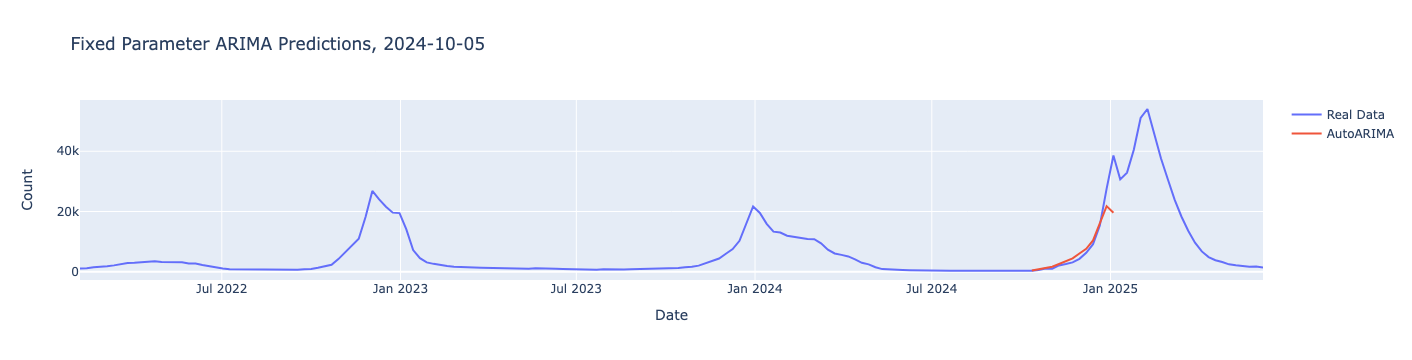

In [67]:
Processor.create_graph()

In [68]:
Processor.forecast

,AutoARIMA
ds,
2024-10-12,384.822226
2024-10-19,792.841102
2024-10-26,1074.005409
2024-11-02,1662.337431
2024-11-09,2566.460561
2024-11-16,3423.245864
2024-11-23,4402.870718
2024-11-30,6035.939686
2024-12-07,7604.154715


In [69]:
Processor.create_metrics()

In [70]:
Processor.create_metrics_df()

In [71]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,2571.587105,3.123659e+07,0.308857,0.240194


In [72]:
Processor.create_display_df()

In [73]:
Processor.display_df

,Reference Date,Target End Date,Quantile,Prediction
0,2024-10-05,2024-10-12,0.5,384.822226
1,2024-10-05,2024-10-19,0.5,792.841102
2,2024-10-05,2024-10-26,0.5,1074.005409
3,2024-10-05,2024-11-02,0.5,1662.337431
4,2024-10-05,2024-11-09,0.5,2566.460561
5,2024-10-05,2024-11-16,0.5,3423.245864
6,2024-10-05,2024-11-23,0.5,4402.870718
7,2024-10-05,2024-11-30,0.5,6035.939686
8,2024-10-05,2024-12-07,0.5,7604.154715
9,2024-10-05,2024-12-14,0.5,10395.552382


In [ ]:
Processor2 = FixedARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [ ]:
Processor2.create_training_dfs(value_col = "value")

In [ ]:
Processor2.load_model(path = "AutoARIMA/fixed_models/testing.pkl")

In [ ]:
Processor2.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing", level = [80, 95])

In [ ]:
Processor2.create_metrics()

In [ ]:
Processor2.create_metrics_df()

In [ ]:
Processor2.metrics_df

In [ ]:
Processor2.forecast

In [ ]:
Processor.forecast

In [ ]:
Processor.forecast.equals(Processor2.forecast)

In [ ]:
class UpdatingARIMAProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
        
        self.color_mapping = {}
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
            
    def create_models(self, h, freq, season_length, model_names, level = []):
        
        if not self.sfs:
            for i in range(len(self.dfs)):
                sf = StatsForecast(models=[AutoARIMA(season_length=season_length)], freq = freq)
                sf.fit(self.dfs[i])
                self.sfs.append(sf)
                sf.save(f"AutoARIMA/updating_models/{model_names[i]}.pkl")

      
        for i in range(len(self.dfs)):
            fc = pd.DataFrame()
            if not level:
                fc = self.sfs[i].predict(h = h)
            else:
                fc = self.sfs[i].predict(h = h, level = level)
            
            fc.set_index("ds", inplace = True)
            fc.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(fc)
    
    def load_models(self, paths):
        for i in range(len(paths)):
            sf = StatsForecast.load(path = paths[i])
            self.sfs.append(sf)
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "AutoARIMA":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['AutoARIMA'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    
    
    
    def create_graph(self):
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            for col in self.forecasts[i].columns:
                if col == "AutoARIMA":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["AutoARIMA"])))
                    
            fig.update_layout(title = f"Updating Parameter ARIMA Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
        
    def calculate_metrics(self):
        col_string = "AutoARIMA"
      
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoARIMA":
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [ ]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [ ]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [ ]:
UProcessor = UpdatingARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [ ]:
UProcessor.create_training_dfs(value_col = "value")

In [ ]:
UProcessor.create_models(h = 4, freq = "W-SAT", season_length = 52, model_names = ["test1", "test2", "test3", "test4", "test5"], level = [80, 95])

In [ ]:
UProcessor.forecasts[4]

In [ ]:
UProcessor.create_graph()

In [ ]:
UProcessor.color_mapping

In [ ]:
UProcessor.calculate_metrics()

In [ ]:
UProcessor.create_metrics_df()

In [ ]:
UProcessor.create_display_df()

In [ ]:
UProcessor.metrics_df

In [ ]:
UProcessor.display_df

In [ ]:
UProcessor2 = UpdatingARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [ ]:
UProcessor2.create_training_dfs(value_col="value")

In [ ]:
model_paths = ["AutoARIMA/updating_models/test1.pkl", "AutoARIMA/updating_models/test2.pkl", "AutoARIMA/updating_models/test3.pkl", 
               "AutoARIMA/updating_models/test4.pkl", "AutoARIMA/updating_models/test5.pkl"]
UProcessor2.load_models(paths = model_paths)

In [ ]:
UProcessor2.create_models(h = 4, freq = "W-SAT", season_length = 52, model_names = ["test1", "test2", "test3", "test4", "test5"], level = [80, 95])

In [ ]:
UProcessor2.create_display_df()

In [ ]:
UProcessor2.display_df

In [ ]:
UProcessor.display_df.equals(UProcessor2.display_df)